# Manipulating GPflow models

One of the key ingredients in GPflow is the model class, which enables you to carefully control parameters. This notebook shows how some of these parameter control features work, and how to build your own model with GPflow. First we'll look at:

 - how to view models and parameters
 - how to set parameter values
 - how to constrain parameters (for example, variance > 0)
 - how to fix model parameters
 - how to apply priors to parameters
 - how to optimise models

Then we'll show how to build a simple logistic regression model, demonstrating the ease of the parameter framework. 

GPy users should feel right at home, but there are some small differences.

First, let's deal with the usual notebook boilerplate and make a simple GP regression model. See [Basic (Gaussian likelihood) GP regression model](../basics/regression.ipynb) for specifics of the model; we just want some parameters to play with.

In [1]:
import gpflow
import numpy as np

Create a very simple GP regression model wrapped in `defer_build()`. You must use `defer_build()` so that the model is not compiled in the TensorFlow graph, because adding transforms and priors is possible only for non-compiled models. 

In [2]:
np.random.seed(1)
X = np.random.rand(20, 1)
Y = np.sin(12 * X) + 0.66 * np.cos(25 * X) + np.random.randn(20,1) * 0.01

with gpflow.defer_build():
    m = gpflow.models.GPR(X, Y, kern=gpflow.kernels.Matern32(1) + gpflow.kernels.Linear(1))

## Viewing, getting, and setting parameters
You can display the state of the model in a terminal by using `print(m)`, and by simply returning it in a notebook:

In [3]:
m

This model has four parameters. The kernel is made of the sum of two parts. The first (counting from zero) is a Matern32 kernel that has a variance parameter and a lengthscale parameter; the second is a linear kernel that has only a variance parameter. There is also a parameter that controls the variance of the noise, as part of the likelihood. 

All the model variables have been initialised at `1.0`. You can access individual parameters in the same way that you display the state of the model in a terminal; for example, to see all the parameters that are part of the likelihood, run:

In [4]:
m.likelihood

This gets more useful with more complex models!

To set the value of a parameter, just use an assignment statement:

In [5]:
m.kern.kernels[0].lengthscales = 0.5
m.likelihood.variance = 0.01
m

## Constraints and trainable variables

GPflow helpfully creates an unconstrained representation of all the variables. In the previous example, all the variables are constrained positively (see the right-hand column in the table), the unconstrained representation is given by $\alpha = \log(\exp(\theta)-1)$. `read_trainables()` returns the constrained values:

In [6]:
m.read_trainables()

{'GPR/kern/kernels/0/lengthscales': array(0.5),
 'GPR/kern/kernels/0/variance': array(1.),
 'GPR/kern/kernels/1/variance': array(1.),
 'GPR/likelihood/variance': array(0.01)}

Each parameter has an `unconstrained_tensor` attribute that enables you to access the unconstrained value as a TensorFlow Tensor (though only after the model has been compiled). You can also check the unconstrained value as follows:

In [7]:
p = m.kern.kernels[0].lengthscales
p.transform.backward(p.value)

-0.4327546710632299

Constraints are handled by the `Transform` classes. You might prefer to use the constraint $\alpha = \log(\theta)$; this is easily done by changing the transform attribute on a parameter, with one simple condition - the model has not been compiled yet:

In [8]:
m.kern.kernels[0].lengthscales.transform = gpflow.transforms.Exp()

Though the lengthscale itself remains the same, the unconstrained lengthscale has changed:

In [9]:
p.transform.backward(p.value)

-0.6931491805619453

Another helpful feature is the ability to fix parameters. To do this, simply set the `trainable` attribute to `False`; this is shown in the **trainable** column of the representation, and the corresponding variable is removed from the free state.

In [10]:
m.kern.kernels[1].variance.trainable = False
m

In [11]:
m.read_trainables()

{'GPR/kern/kernels/0/lengthscales': array(0.5),
 'GPR/kern/kernels/0/variance': array(1.),
 'GPR/likelihood/variance': array(0.01)}

To unfix a parameter, just set the `trainable` attribute to `True` again.

In [12]:
m.kern.kernels[1].variance.trainable = True
m

## Priors

You can set priors in the same way as transforms and trainability, by using members of the `gpflow.priors` module. Let's set a Gamma prior on the RBF-variance.

In [13]:
m.kern.kernels[0].variance.prior = gpflow.priors.Gamma(2, 3)
m

## Optimisation

To optimise your model, first create an instance of an optimiser (in this case, `gpflow.train.ScipyOptimizer`), which has optional arguments that are passed to `scipy.optimize.minimize` (we minimise the negative log likelihood). Then, call the `minimize` method of that optimiser, with your model as the optimisation target. Variables that have priors are maximum a priori (MAP) estimated, that is, we add the log prior to the log likelihood, and otherwise use Maximum Likelihood.

In [14]:
m.compile()
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m)

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 1.884455
  Number of iterations: 41
  Number of functions evaluations: 46


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 1.884455
  Number of iterations: 41
  Number of functions evaluations: 46


## Building new models

To build new models, you'll need to inherit from `gpflow.models.Model`. Parameters are instantiated with `gpflow.Param`. You might also be interested in `gpflow.params.Parameterized`, which acts as a 'container' for `Param`s (for example, kernels are parameterised). 

In this very simple demo, we'll implement linear multiclass classification.

There are two parameters: a weight matrix and a bias (offset). The key thing to implement is the private `_build_likelihood` method, which returns a TensorFlow scalar that represents the (log) likelihood. You can use param objects inside `_build_likelihood`, but you need to use the constrained tensor attribute to access the tensor to use when building the graph (for example, `self.kernel.variance.constrained_tensor`).

Alternatively, decorate the function with `@gpflow.params_as_tensors` so that the objects appear as constrained tensors (for example, you can now refer to the TensorFlow object as `self.kernel.variance` rather than `self.kernel.variance.constrained_tensor`). This is useful when you are writing the model likelihood and dealing with the `constrained_tensor` attributes of several different `Param`s, but note that you cannot access any of the other features of a `Param` object.


In [15]:
import tensorflow as tf

class LinearMulticlass(gpflow.models.Model):
    def __init__(self, X, Y, name=None):
        super().__init__(name=name) # always call the parent constructor
        
        self.X = X.copy() # X is a numpy array of inputs
        self.Y = Y.copy() # Y is a 1-of-k (one-hot) representation of the labels
        
        self.num_data, self.input_dim = X.shape
        _, self.num_classes = Y.shape
        
        #make some parameters
        self.W = gpflow.Param(np.random.randn(self.input_dim, self.num_classes))
        self.b = gpflow.Param(np.random.randn(self.num_classes))
       
        # ^^ You must make the parameters attributes of the class for
        # them to be picked up by the model. i.e. this won't work:
        #
        # W = gpflow.Param(...    <-- must be self.W
    
    @gpflow.params_as_tensors
    def _build_likelihood(self): # takes no arguments
        p = tf.nn.softmax(tf.matmul(self.X, self.W) + self.b) # Param variables are used as tensorflow arrays. 
        return tf.reduce_sum(tf.log(p) * self.Y) # be sure to return a scalar

...and that's it. Let's build a really simple demo to show that it works.

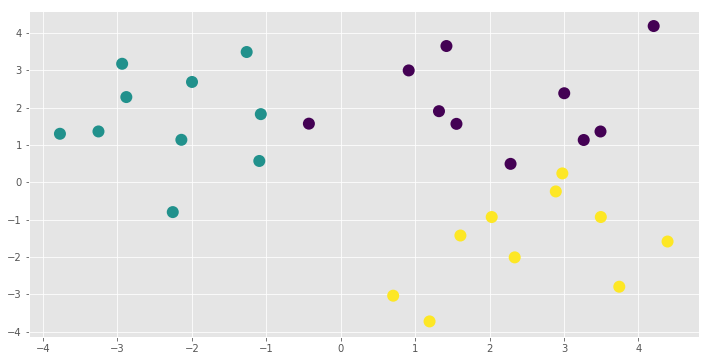

In [16]:
np.random.seed(123)
X = np.vstack([np.random.randn(10,2) + [2,2],
               np.random.randn(10,2) + [-2,2],
               np.random.randn(10,2) + [2,-2]])
Y = np.repeat(np.eye(3), 10, 0)

from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12,6)
plt.scatter(X[:,0], X[:,1], 100, np.argmax(Y, 1), lw=2, cmap=plt.cm.viridis);

In [17]:
m = LinearMulticlass(X, Y)
m

In [18]:
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m)
m

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 0.000013
  Number of iterations: 26
  Number of functions evaluations: 27


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 0.000013
  Number of iterations: 26
  Number of functions evaluations: 27


In [19]:
xx, yy = np.mgrid[-4:4:200j, -4:4:200j]
X_test = np.vstack([xx.flatten(), yy.flatten()]).T
f_test = np.dot(X_test, m.W.read_value()) + m.b.read_value()
p_test = np.exp(f_test)
p_test /= p_test.sum(1)[:,None]

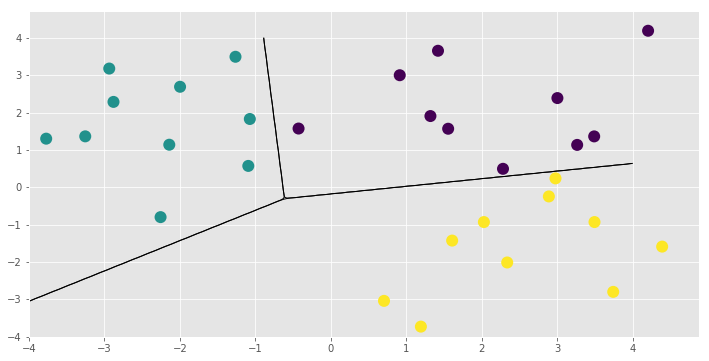

In [20]:
plt.figure(figsize=(12, 6))
for i in range(3):
    plt.contour(xx, yy, p_test[:,i].reshape(200,200), [0.5], colors='k', linewidths=1)
plt.scatter(X[:,0], X[:,1], 100, np.argmax(Y, 1), lw=2, cmap=plt.cm.viridis);

That concludes the new model example and this notebook. You might want to see for yourself that the `LinearMulticlass` model and its parameters have all the functionality demonstrated here. You could also add some priors and run Hamiltonian Monte Carlo using the HMC optimiser `gpflow.train.HMC` and its `sample` method. See [Markov Chain Monte Carlo (MCMC)](../advanced/mcmc.ipynb) for more information on running the sampler.